In [ ]:
# Second File to run. Run analysis.ipynb first.
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
import support_functions as sf
import statistical_analysis as sa
import importlib, support_functions, inspect, statistical_analysis
importlib.reload(support_functions)
importlib.reload(statistical_analysis)
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

path = Path("data") / "df_merge_daily.csv"
data_daily = pd.read_csv(path)
data_daily['date'] = pd.to_datetime(data_daily['date'])
data_daily.set_index('date', inplace=True)
path = Path("data") / "df_merge_weekly.csv"
data_weekly = pd.read_csv(path)
data_weekly['date'] = pd.to_datetime(data_weekly['date'])
data_weekly.set_index('date', inplace=True)

# Add calendar week from index
data_weekly['calendar_week'] = data_weekly.index.isocalendar().week
# raw_data.sample(3)

In [ ]:
df_merge_daily_2019 = data_daily[data_daily.index.year == 2019]
df_merge_daily_2020 = data_daily[data_daily.index.year == 2020]
df_merge_daily_2021 = data_daily[data_daily.index.year == 2021]

### Correlation & Variable Selection

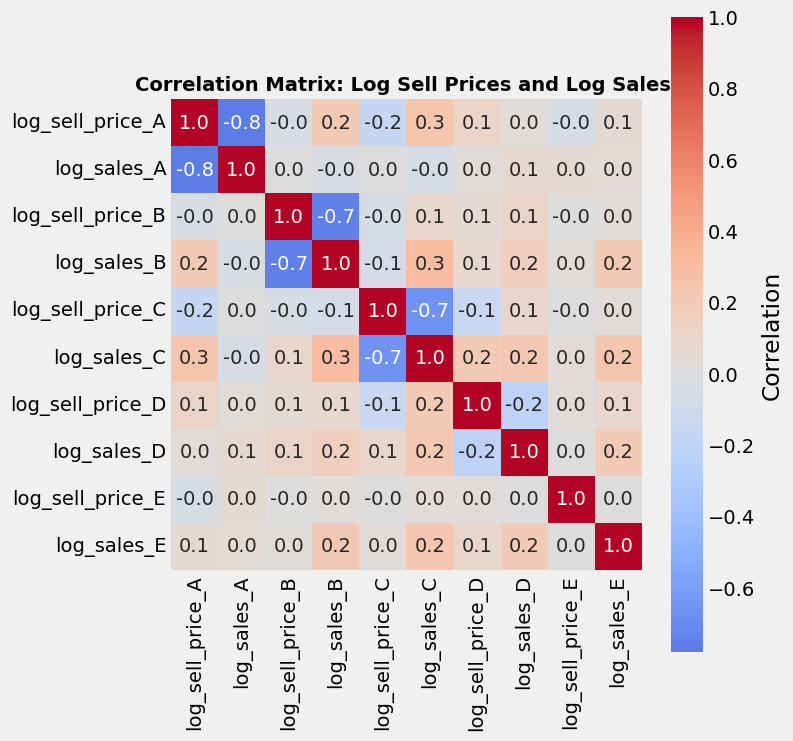

In [ ]:
df_corr_daily = sa.log_correlation_plot(data_daily)

Available temporal columns: ['dayofweek', 'dayofmonth', 'dayofyear', 'month', 'year', 'is_weekend']


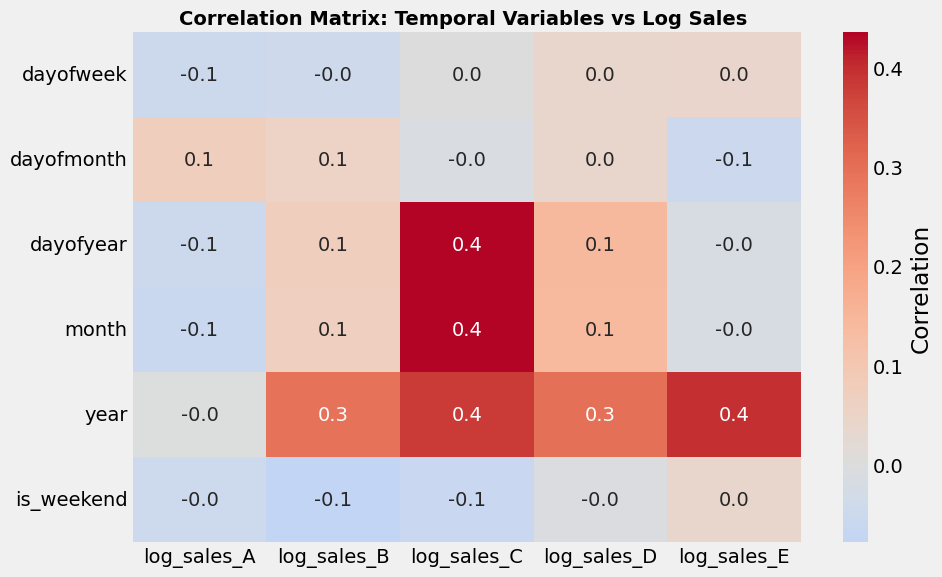

In [ ]:
df_temporal_corr_daily = sa.temporal_sales_correlation_plot(data_daily)

In [ ]:
# df_corr_daily_2019 = sa.log_correlation_plot(df_merge_daily_2019)
# df_corr_daily_2020 = sa.log_correlation_plot(df_merge_daily_2020)

In [ ]:
log_dependent_cols = [
    'log_sales_A', 'log_sales_B', 'log_sales_C',
    'log_sales_D', 'log_sales_E'
]
regression_columns_daily = {}
# df_corr.loc['log_sales_A'][np.abs(df_corr.loc['log_sales_A']) > 0.5].drop('log_sales_A')
for col in log_dependent_cols:
    independent_variables = []
    corr_cols = df_corr_daily.loc[col][np.abs(df_corr_daily.loc[col]) > 0.5].drop(col)
    print(f"Columns correlated with {col} (|corr| > 0.5):")
    if len(corr_cols) == 0:
        print(f"  {col} is not correlated with any of the given values")
        regression_columns_daily.setdefault(col, [])
    else:
        for c, val in corr_cols.items():
            regression_columns_daily.setdefault(col, []).append(c)
            print(f"  {c}: {val:.4f}")
    
    # Add temporal correlations
    if col in df_temporal_corr_daily.columns:
        temporal_corr_cols = df_temporal_corr_daily[col][np.abs(df_temporal_corr_daily[col]) > 0.5]
        print(f"Temporal columns correlated with {col} (|corr| > 0.5):")
        if len(temporal_corr_cols) == 0:
            print(f"  No temporal columns correlated")
        else:
            for c, val in temporal_corr_cols.items():
                if c not in regression_columns_daily[col]:
                    regression_columns_daily[col].append(c)
                print(f"  {c}: {val:.4f}")
    print('*'*30)
print("Regression Columns Dictionary:")
print(regression_columns_daily)

Columns correlated with log_sales_A (|corr| > 0.5):
  log_sell_price_A: -0.7804
Temporal columns correlated with log_sales_A (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_B (|corr| > 0.5):
  log_sell_price_B: -0.7490
Temporal columns correlated with log_sales_B (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_C (|corr| > 0.5):
  log_sell_price_C: -0.6680
Temporal columns correlated with log_sales_C (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_D (|corr| > 0.5):
  log_sales_D is not correlated with any of the given values
Temporal columns correlated with log_sales_D (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_E (|corr| > 0.5):
  log_sales_E is not correlated with any of the given values
Temporal columns correlated with l

In [ ]:
regression_columns_daily

{'log_sales_A': ['log_sell_price_A'],
 'log_sales_B': ['log_sell_price_B'],
 'log_sales_C': ['log_sell_price_C'],
 'log_sales_D': [],
 'log_sales_E': []}

#### Weekly

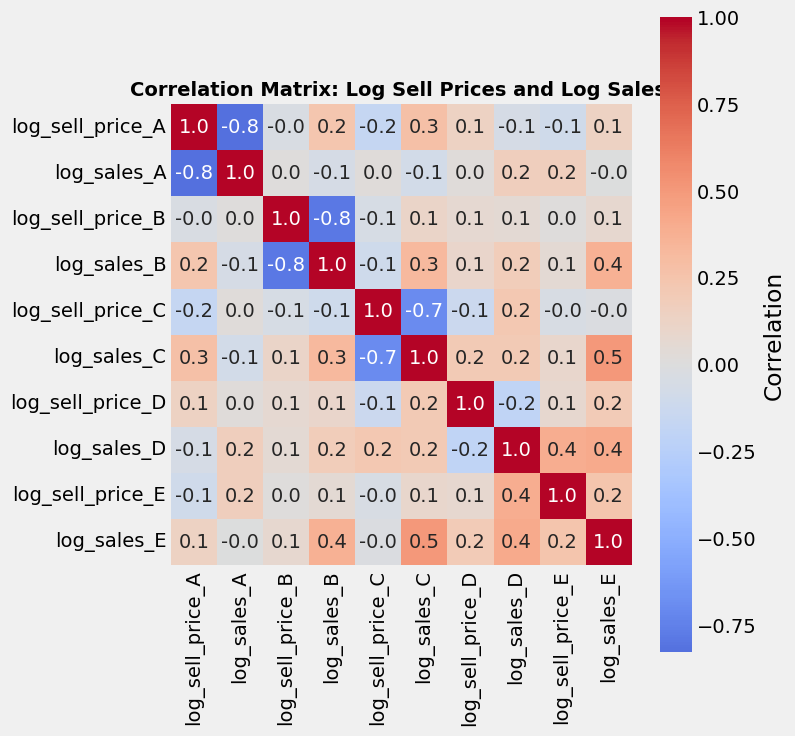

In [ ]:
df_corr_weekly = sa.log_correlation_plot(data_weekly)

In [ ]:
data_weekly.columns

Index(['sales_A', 'sell_price_A', 'margin_A', 'revenue_A', 'cost_A',
       'running_week_A', 'log_sell_price_A', 'log_sales_A', 'log_revenue_A',
       'log_running_week_A', 'sales_B', 'sell_price_B', 'margin_B',
       'revenue_B', 'cost_B', 'running_week_B', 'log_sell_price_B',
       'log_sales_B', 'log_revenue_B', 'log_running_week_B', 'sales_C',
       'sell_price_C', 'margin_C', 'revenue_C', 'cost_C', 'running_week_C',
       'log_sell_price_C', 'log_sales_C', 'log_revenue_C',
       'log_running_week_C', 'sales_D', 'sell_price_D', 'margin_D',
       'revenue_D', 'cost_D', 'running_week_D', 'log_sell_price_D',
       'log_sales_D', 'log_revenue_D', 'log_running_week_D', 'sales_E',
       'sell_price_E', 'margin_E', 'revenue_E', 'cost_E', 'running_week_E',
       'log_sell_price_E', 'log_sales_E', 'log_revenue_E',
       'log_running_week_E', 'dayofweek', 'is_weekend', 'dayofmonth',
       'dayofyear', 'month', 'year', 'calendar_week'],
      dtype='object')

Available temporal columns: ['dayofmonth', 'dayofyear', 'month', 'calendar_week', 'log_running_week']


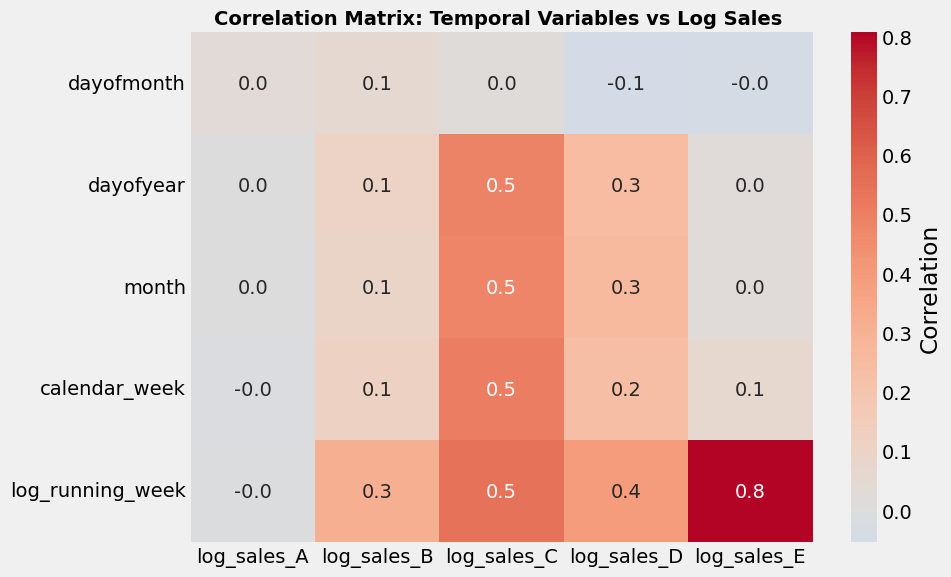

,log_sales_A,log_sales_B,log_sales_C,log_sales_D,log_sales_E
dayofmonth,0.027406,0.051455,0.017054,-0.054064,-0.045052
dayofyear,0.006292,0.102226,0.484725,0.250596,0.024009
month,0.004390,0.097167,0.482728,0.255361,0.024268
calendar_week,-0.012144,0.117880,0.506023,0.238168,0.060915
log_running_week,-0.006360,0.310034,0.547378,0.394247,0.806306


In [ ]:
# Add log_running_week columns for each product to data_weekly
min_date = data_weekly.index.min()
data_weekly['running_week'] = np.ceil((data_weekly.index - min_date).days / 7).astype(int) + 1
data_weekly['log_running_week'] = np.log(data_weekly['running_week'])

# Create product-specific log_running_week columns
for product in ['A', 'B', 'C', 'D', 'E']:
    data_weekly[f'log_running_week_{product}'] = data_weekly['log_running_week']

df_temporal_corr_weekly = sa.temporal_sales_correlation_plot(data_weekly)
df_temporal_corr_weekly

In [ ]:
log_dependent_cols = [
    'log_sales_A', 'log_sales_B', 'log_sales_C',
    'log_sales_D', 'log_sales_E'
]
regression_columns_weekly = {}
# df_corr.loc['log_sales_A'][np.abs(df_corr.loc['log_sales_A']) > 0.5].drop('log_sales_A')
for col in log_dependent_cols:
    corr_cols = df_corr_weekly.loc[col][np.abs(df_corr_weekly.loc[col]) > 0.5].drop(col)
    print(f"Columns correlated with {col} (|corr| > 0.5):")
    if len(corr_cols) == 0:
        print(f"  {col} is not correlated with any of the given values")
        regression_columns_weekly.setdefault(col, [])
    else:
        for c, val in corr_cols.items():
            regression_columns_weekly.setdefault(col, []).append(c)
            print(f"  {c}: {val:.4f}")
    
    # Add temporal correlations
    if col in df_temporal_corr_weekly.columns:
        temporal_corr_cols = df_temporal_corr_weekly[col][np.abs(df_temporal_corr_weekly[col]) > 0.5]
        print(f"Temporal columns correlated with {col} (|corr| > 0.5):")
        if len(temporal_corr_cols) == 0:
            print(f"  No temporal columns correlated")
        else:
            for c, val in temporal_corr_cols.items():
                # Skip 'is_weekend' for weekly data
                if c == 'is_weekend':
                    continue
                if c not in regression_columns_weekly[col]:
                    regression_columns_weekly[col].append(c)
                print(f"  {c}: {val:.4f}")
    print('*'*30)
print("Regression Columns Dictionary:")
print(regression_columns_weekly)

Columns correlated with log_sales_A (|corr| > 0.5):
  log_sell_price_A: -0.8288
Temporal columns correlated with log_sales_A (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_B (|corr| > 0.5):
  log_sell_price_B: -0.7870
Temporal columns correlated with log_sales_B (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_C (|corr| > 0.5):
  log_sell_price_C: -0.6960
  log_sales_E: 0.5061
Temporal columns correlated with log_sales_C (|corr| > 0.5):
  calendar_week: 0.5060
  log_running_week: 0.5474
******************************
Columns correlated with log_sales_D (|corr| > 0.5):
  log_sales_D is not correlated with any of the given values
Temporal columns correlated with log_sales_D (|corr| > 0.5):
  No temporal columns correlated
******************************
Columns correlated with log_sales_E (|corr| > 0.5):
  log_sales_C: 0.5061
Temporal columns correlated with 

In [ ]:
regression_columns_weekly

{'log_sales_A': ['log_sell_price_A'],
 'log_sales_B': ['log_sell_price_B'],
 'log_sales_C': ['log_sell_price_C',
  'log_sales_E',
  'calendar_week',
  'log_running_week'],
 'log_sales_D': [],
 'log_sales_E': ['log_sales_C', 'log_running_week']}

In [ ]:
for k,v in regression_columns_weekly.items():
    print(k,v)

log_sales_A ['log_sell_price_A']
log_sales_B ['log_sell_price_B']
log_sales_C ['log_sell_price_C', 'log_sales_E', 'calendar_week', 'log_running_week']
log_sales_D []
log_sales_E ['log_sales_C', 'log_running_week']


## 📌 Summary of Regression Metrics

### 📊 When to Use Each Metric

- **MAE (Mean Absolute Error):**
  - Use for a **straightforward average error**.
  - Robust to outliers.
  - Good for when all errors should be treated equally.

- **RMSE (Root Mean Squared Error):**
  - Use when you want to **penalize large errors more**.
  - Good for cases where big mistakes are costly.
  - Keeps units of the target variable.

- **R² (Coefficient of Determination):**
  - Use to understand how well the model **explains variance** in the target.
  - Not a direct measure of error magnitude.
  - Useful for goodness-of-fit comparisons.

### 🧠 Key Differences

- **RMSE ≥ MAE** for the same predictions — because RMSE emphasizes large errors.
- **MAE** reflects average absolute error.
- **RMSE** reflects squared error sensitivity.
- **R²** shows the proportion of variance explained, not error size.

### 📍 Quick Rule of Thumb

| Goal                                      | Best Metric |
|-------------------------------------------|-------------|
| Understand average size of prediction errors | **MAE**     |
| Emphasize big errors                      | **RMSE**    |
| Explain variance / goodness of fit        | **R²**      |


### Daily

In [ ]:
# Create product-specific dataframes for regression using regression_columns_weekly
for product in ['A', 'B', 'C', 'D', 'E']:
    target_col = f'log_sales_{product}'
    feature_cols = regression_columns_daily.get(target_col, [])
    
    if len(feature_cols) > 0:
        cols_to_select = [target_col] + feature_cols
        # Only select columns that exist in data_daily
        cols_to_select = [col for col in cols_to_select if col in data_daily.columns]
        df_name = f'data_daily_{product}'
        globals()[df_name] = data_daily[cols_to_select].dropna()
        print(f"Product {product}: {len(globals()[df_name])} rows, features: {cols_to_select}")
    else:
        print(f"Product {product}: No features available (skipped)")

Product A: 755 rows, features: ['log_sales_A', 'log_sell_price_A']
Product B: 739 rows, features: ['log_sales_B', 'log_sell_price_B']
Product C: 737 rows, features: ['log_sales_C', 'log_sell_price_C']
Product D: No features available (skipped)
Product E: No features available (skipped)


In [ ]:
# Export data_daily_A/B/C/D to CSV
from pathlib import Path

data_folder = Path("data")

for product in ['A', 'B', 'C', 'D']:
    df_name = f'data_daily_{product}'
    if df_name in globals():
        df = globals()[df_name]
        csv_path = data_folder / f'{df_name}.csv'
        df.to_csv(csv_path)
        print(f"Saved {df_name} to {csv_path}")
    else:
        print(f"{df_name} not found in globals()")

Saved data_daily_A to data/data_daily_A.csv
Saved data_daily_B to data/data_daily_B.csv
Saved data_daily_C to data/data_daily_C.csv
data_daily_D not found in globals()


Weekly Regression

In [37]:
# Create product-specific dataframes for regression using regression_columns_weekly
for product in ['A', 'B', 'C', 'D', 'E']:
    target_col = f'log_sales_{product}'
    feature_cols = regression_columns_weekly.get(target_col, [])
    
    if len(feature_cols) > 0:
        cols_to_select = [target_col] + feature_cols
        # Only select columns that exist in data_weekly
        cols_to_select = [col for col in cols_to_select if col in data_weekly.columns]
        df_name = f'data_weekly_{product}'
        globals()[df_name] = data_weekly[cols_to_select].dropna()
        print(f"Product {product}: {len(globals()[df_name])} rows, features: {cols_to_select}")
    else:
        print(f"Product {product}: No features available (skipped)")

Product A: 109 rows, features: ['log_sales_A', 'log_sell_price_A']
Product B: 109 rows, features: ['log_sales_B', 'log_sell_price_B']
Product C: 95 rows, features: ['log_sales_C', 'log_sell_price_C', 'log_sales_E', 'calendar_week', 'log_running_week']
Product D: No features available (skipped)
Product E: 95 rows, features: ['log_sales_E', 'log_sales_C', 'log_running_week']


In [38]:
# Export data_weekly_A/B/C/D/E to CSV
data_folder = Path("data")

for product in ['A', 'B', 'C', 'D', 'E']:
    df_name = f'data_weekly_{product}'
    if df_name in globals():
        df = globals()[df_name]
        csv_path = data_folder / f'{df_name}.csv'
        df.to_csv(csv_path)
        print(f"Saved {df_name} to {csv_path}")
    else:
        print(f"{df_name} not found in globals()")

Saved data_weekly_A to data/data_weekly_A.csv
Saved data_weekly_B to data/data_weekly_B.csv
Saved data_weekly_C to data/data_weekly_C.csv
data_weekly_D not found in globals()
Saved data_weekly_E to data/data_weekly_E.csv


We have used **power-law demand function:**
$$ ln(q) = \beta_0 + \beta_1 ln(p) $$
$$ q(p) = e^{\beta_0} e^{\beta_1 ln(p)} = e^{\beta_0} e^{ln(p^{\beta_1})} = e^{\beta_0} p^{\beta1} $$
$$R(p) = p \times q(p) = e^{\beta_0} \times p^{\beta_1 + 1}$$
Using FOC (to maximize revenue):
$$\frac{dR}{dp} = 0 \implies \frac{e^{\beta_0} \times p^{\beta_1 + 1}}{dp} = 0$$
$$\implies \beta_1 = -1$$



In [ ]:
data = df_merge_daily[['sell_price_A','sales_A','log_sales_A','log_sell_price_A']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_A':'price','sales_A':'sales',
        'log_sell_price_A':'ln_price','log_sales_A':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


In [ ]:
# Demand function
def demand(p):
    return np.exp(beta0) * p**beta1

# Revenue function
def revenue(p):
    return p * demand(p)


In [ ]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

In [ ]:
linear_regression_statsmodels(df_merge_daily, product ='B')

In [ ]:
linear_regression_statsmodels(df_merge, product ='C')

In [ ]:
linear_regression_statsmodels(df_merge, product ='D')

In [ ]:
linear_regression_statsmodels(df_merge, product ='E')

In [ ]:

def plot_price_sales(fdf, product_name):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    print("Here")

    # Plot sales over time
    axes[0].plot(fdf.index, fdf[f'log_sales_{product_name}'], marker='o', linestyle='-', linewidth=2)
    axes[0].set_title(f'{product_name} - Log Sales Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Log Sales')
    axes[0].grid(True, alpha=0.3)

    # Plot sell_price over time
    axes[1].plot(fdf.index, fdf[f'log_sell_price_{product_name}'], marker='s', linestyle='-', linewidth=2, color='orange')
    axes[1].set_title(f'{product_name} - Log Sell Price Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Log Sell Price')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_price_sales(df_merge, 'A')
# plot_price_sales(df_merge, 'B')
# plot_price_sales(df_merge, 'C')
# plot_price_sales(df_merge, 'D')
plot_price_sales(df_merge, 'E')

In [ ]:
# Plot log sales for all products
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    axes[idx].plot(df_prod.index, df_prod[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot log sales for all products - 2019 only
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    df_2019 = df_prod[df_prod.index.year == 2019]
    axes[idx].plot(df_2019.index, df_2019[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time (2019)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot log sales for all products - 2020 only
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    df_2020 = df_prod[df_prod.index.year == 2020]
    axes[idx].plot(df_2020.index, df_2020[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time (2020)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def plot_price_sales_correlation(df_product, product_name):
    # Correlation plot between sell_price and sales
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(df_product['log_price'], df_product['log_sales'], alpha=0.6, s=50, color='steelblue')
    ax.set_xlabel('Log Sell Price', fontsize=12, fontweight='bold')
    ax.set_ylabel('Log Sales', fontsize=12, fontweight='bold')
    ax.set_title(f'{product_name} - Correlation between Log Sell Price and Log Sales', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add correlation coefficient
    corr = df_product['log_price'].corr(df_product['log_sales'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# plot_price_sales_correlation(df_product_A, 'Product A')
# plot_price_sales_correlation(df_product_B, 'Product B')
# plot_price_sales_correlation(df_product_C, 'Product C')
# plot_price_sales_correlation(df_product_D, 'Product D')
plot_price_sales_correlation(df_product_E, 'Product E')

In [ ]:
# # Day-wise boxplot of sales
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sales'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightblue')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Sales Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sales')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Day-wise boxplot of sell_price
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sell_price'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightcoral')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Price Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sell Price')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# Density plot for df_merge['log_sell_price_E']
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column exists and drop NA values
col = 'log_sell_price_E'
if col not in df_merge.columns:
    raise KeyError(f"{col} not found in df_merge columns: {df_merge.columns.tolist()}")

data = df_merge[col].dropna()
if data.shape[0] == 0:
    print(f'No non-null values found for {col}')
else:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data, fill=True, bw_method='scott', color='C0')
    plt.title('Density plot: log_sell_price_E', fontsize=14, fontweight='bold')
    plt.xlabel('log_sell_price_E')
    plt.ylabel('Density')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Product E

In [ ]:
df_product_E.dropna(inplace=True)
df_product_E['revenue_E'] = df_product_E['sell_price_E'] * df_product_E['sales_E']
df_product_E

In [ ]:
mode_E = df_product_E['log_sell_price_E'].mode()
print(type(mode_E))
print(mode_E.iloc[0] )
df_product_E['flag_discount_E'] = np.where(
    df_product_E['log_sell_price_E'] < mode_E.iloc[0]*0.98, 1, 0
)
df_product_E['percentage_discount_E'] =  (mode_E.iloc[0] - df_product_E['log_sell_price_E']) / mode_E.iloc[0] * 100
df_product_E['percentage_discount_E'].value_counts()

In [ ]:

# Create continuous week column for df_product_E (based on elapsed time from earliest date)
min_date = df_product_E.index.min()
df_product_E['week'] = np.ceil((df_product_E.index - min_date).days / 7).astype(int)
# Ensure week starts at 1 (not 0)
df_product_E['week'] = df_product_E['week'] + 1
print(f"Week column created. Min date: {min_date}, Unique weeks: {sorted(df_product_E['week'].unique())}")
# print(df_product_E[['week']].head(15))

In [ ]:
df_product_E

In [ ]:
col_names = ['sell_price_E','sales_E','log_sales_E','log_sell_price_E','flag_discount_E','week']
data = df_product_E[col_names].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_E':'price','sales_E':'sales',
        'log_sell_price_E':'ln_price','log_sales_E':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['week'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


In [ ]:
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

In [ ]:
# Regression function already defined in cell 18 - using that definition


In [ ]:
independent_variables_columns = ['week','percentage_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','flag_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','log_sell_price_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
df_product_E.groupby('week')['sales_E'].sum().plot()

In [ ]:
df_product_E.groupby('week')['sell_price_E'].mean().plot()

In [ ]:
df_product_A['sell_price_A'].plot()

In [ ]:
# Create log_running_week for data_weekly
min_date = data_weekly.index.min()
data_weekly['running_week'] = np.ceil((data_weekly.index - min_date).days / 7).astype(int) + 1
data_weekly['log_running_week'] = np.log(data_weekly['running_week'])

# Generate temporal_sales_correlation_plot for data_weekly
df_temporal_corr_weekly = sa.temporal_sales_correlation_plot(data_weekly, title_suffix='(Weekly Data)')


In [ ]:
data_weekly.sample(10)